<a href="https://colab.research.google.com/github/IevgenTs/uoft-ml-3253-assignments/blob/main/module-04-unsupervised-clustering/module_04_unsupervised_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Creating the `images/unsupervised_learning` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures.

# Importing Data

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

#Mount your Google drive so you can read them easily
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Data - ElectricityLoadDiagrams20112014:

https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

In [ ]:
import fileinput

#STEP 1: Download data file from server (https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip)
#STEP 2: Unzip the file and upload it to your Google Drive - Remember where you stored it

#Update below address to point to your google drive
filePath = "/content/gdrive/MyDrive/Colab Notebooks/04_SLS-3253_Module 4 - Clustering and Unsupervised Learning/LD2011_2014.txt"

In [ ]:

# Create dataframe
import pandas as pd
data = pd.read_csv(filePath, sep=";", low_memory=False, index_col=0, decimal=',')

In [ ]:
# To ensure you have the right data, make sure your data.shape output is (140256, 370).
# Otherwise, you data file is corrupt and have to read data again. Copy the original file from Saeid's shared Google Drive and run the code again.
data.shape

(140256, 370)

In [ ]:
# Question 1 in Assignment 4
mean_value = data.iloc[:, 256].mean()  # iloc[:, 256] selects the 257th column
print(mean_value)

156.41463973047266


# Data inspection

Data set has no missing values.
Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.
All time labels report to Portuguese hour. However all days present 96 measures (24*4). Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points. Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.

In [ ]:
data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.tail()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.175240,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


Dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.
Since the frequency is 15 minutes, each day provides 24 * 4 =96
 datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: 96 * 365 *4 + 96 =140256
, as observed in data.shape

In [ ]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


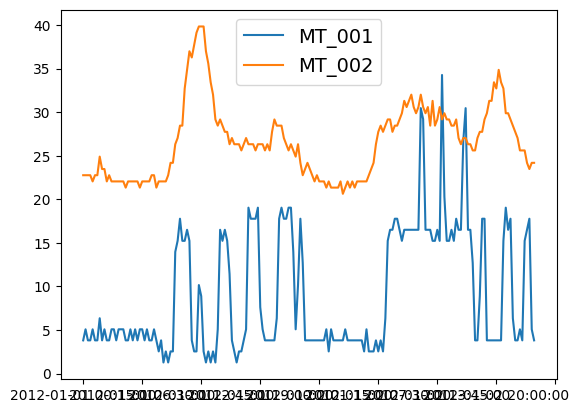

In [ ]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

# Data processing

In [ ]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [ ]:

# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [ ]:
# See number of clients with 0 demand per year
# Print the number of clients who had zero average electricity consumption
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [ ]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand

# Add data of 2014 at the end of df consist of 2013 data

# -- > below line of code not functional
#data_13_14 = data2013.append(data2014) # appending 2013 and 2014

# Use pd.concat instead of append
data_13_14 = pd.concat([data2013, data2014], ignore_index=False)  # Concatenate data2013 and data2014

# drop clients with 0 demand
data_13_14 = data_13_14.drop(clients_no_demand, axis=1)
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


In [ ]:
data_13_14.copy()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,64.953605,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,61.384725,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,42.826552,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649
2013-01-01 01:00:00,1.269036,23.470839,2.606429,130.081301,56.097561,226.190476,6.218202,249.158249,50.699301,75.268817,...,44.254104,15800.0,860.759494,840.909091,16.949153,4.095963,575.065847,58.430718,722.873900,7848.648649
2013-01-01 01:15:00,3.807107,23.470839,2.606429,130.081301,58.536585,229.166667,6.783493,239.057239,57.692308,74.193548,...,44.254104,15000.0,793.248945,818.181818,16.949153,4.095963,570.676032,60.100167,748.533724,7610.810811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


# Getting average curves per client

In [ ]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [ ]:
# Extracting the time of day from the timestamp index and storing it in a separate column called hour
data['hour'] = data.index.map(lambda x: x[11:])

In [ ]:
data.head(97)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00
2013-01-01 01:00:00,1.269036,23.470839,2.606429,130.081301,56.097561,226.190476,6.218202,249.158249,50.699301,75.268817,...,15800.0,860.759494,840.909091,16.949153,4.095963,575.065847,58.430718,722.873900,7848.648649,01:00:00
2013-01-01 01:15:00,3.807107,23.470839,2.606429,130.081301,58.536585,229.166667,6.783493,239.057239,57.692308,74.193548,...,15000.0,793.248945,818.181818,16.949153,4.095963,570.676032,60.100167,748.533724,7610.810811,01:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01 23:15:00,2.538071,24.182077,3.475239,162.601626,69.512195,217.261905,4.522329,262.626263,52.447552,79.569892,...,30000.0,1160.337553,2340.909091,16.949153,7.021650,530.289728,65.108514,724.340176,6659.459459,23:15:00
2013-01-01 23:30:00,1.269036,24.182077,3.475239,144.308943,69.512195,232.142857,4.522329,249.158249,55.944056,81.720430,...,28200.0,1168.776371,2159.090909,18.252934,5.851375,499.561018,58.430718,730.205279,6183.783784,23:30:00
2013-01-01 23:45:00,2.538071,23.470839,3.475239,134.146341,70.731707,220.238095,4.522329,235.690236,52.447552,79.569892,...,27700.0,1151.898734,1386.363636,16.949153,4.681100,479.367867,56.761269,722.873900,6897.297297,23:45:00
2013-01-02 00:00:00,1.269036,23.470839,3.475239,126.016260,69.512195,217.261905,5.087620,225.589226,48.951049,79.569892,...,27700.0,1135.021097,1340.909091,16.949153,9.362200,484.635645,56.761269,738.269795,6897.297297,00:00:00


In [ ]:
data.shape

(70080, 350)

In [ ]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape

(96, 349)

In [ ]:
#average_curves.head()

The dataframe average_curves contains the 349 typical weekday electric demands
We now divide each curve by its mean, so that all curves have mean 1

In [ ]:
average_curves_norm = average_curves/(average_curves.mean())

Plot the first 2 and last 2 clients

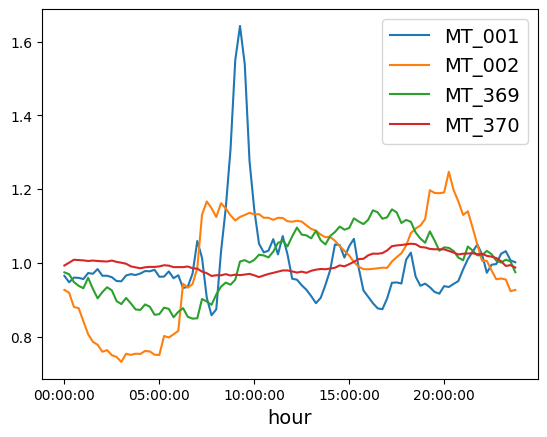

In [ ]:

average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

In [ ]:
average_curves_norm.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.964792,0.926674,0.991800,1.140106,1.186498,1.008914,1.170686,0.946572,0.983915,0.948867,...,0.414676,0.748555,0.561491,0.430085,0.471574,1.358632,1.215272,1.170441,0.974307,0.992967
00:15:00,0.947378,0.919117,0.977796,1.099159,1.131703,0.946419,1.118666,0.909376,0.953996,0.924425,...,0.414381,0.662602,0.412336,0.375704,0.423108,1.365299,1.184899,1.223818,0.969266,1.000548
00:30:00,0.960104,0.880744,0.976579,1.061641,1.090238,0.905552,1.081459,0.881217,0.931614,0.908674,...,0.386706,0.561815,0.395294,0.344682,0.386975,1.312627,1.177781,1.211343,0.947969,1.008515


# Exercise 1

## Determining optimal number of clusters

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# Checking data format
average_curves_norm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 00:00:00 to 23:45:00
Columns: 349 entries, MT_001 to MT_370
dtypes: float64(349)
memory usage: 264.6+ KB


In [ ]:
# Convert to a NumPy array
# X = average_curves_norm.values

In [ ]:
# X.shape

In [ ]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

In [ ]:
print(X)

[[0.96479215 0.94737834 0.96010381 ... 1.03176835 1.00665227 1.00162906]
 [0.92667365 0.91911689 0.8807438  ... 0.95492484 0.9233459  0.92656966]
 [0.99179969 0.97779638 0.9765787  ... 1.00397648 0.99849693 0.99301737]
 ...
 [1.17044059 1.22381837 1.21134255 ... 1.17431116 1.15378816 1.13637963]
 [0.97430716 0.96926554 0.94796904 ... 1.00867049 1.00368029 0.97461078]
 [0.99296729 1.00054813 1.00851498 ... 0.99165659 0.99394714 0.98743097]]


### Number of clusters based on inertia - Option 1

In [ ]:
# Define range of k values to test
k_values = range(1, 16)
inertia_values = []

In [ ]:
# Compute inertia for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

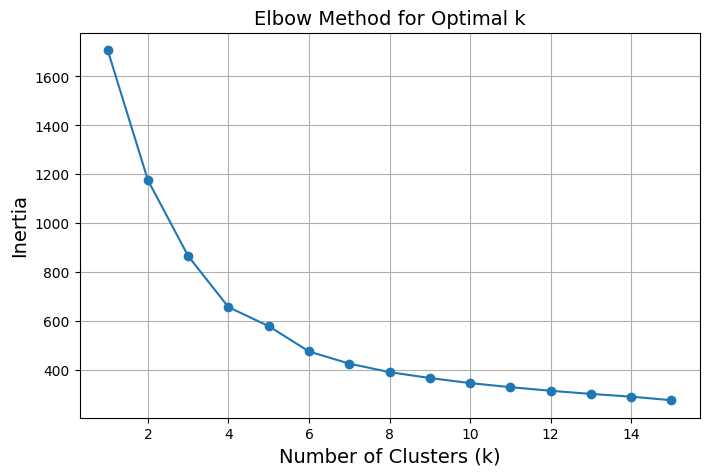

In [ ]:
# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid()
plt.show()

In [ ]:
inertia_values

[1707.2294200296335,
 1175.527275423089,
 865.9677208804294,
 657.6442657822125,
 580.0050647357748,
 476.4846803515837,
 426.96632664072143,
 392.1663773569886,
 368.1029638307626,
 347.47911342784647,
 330.7687819706376,
 316.05262279923085,
 303.12989088966236,
 292.1069156599554,
 277.42881371357544]

### Inertia calcualtion based "getInertia" function - Option 2

In [ ]:
#function for calculating inertia
def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

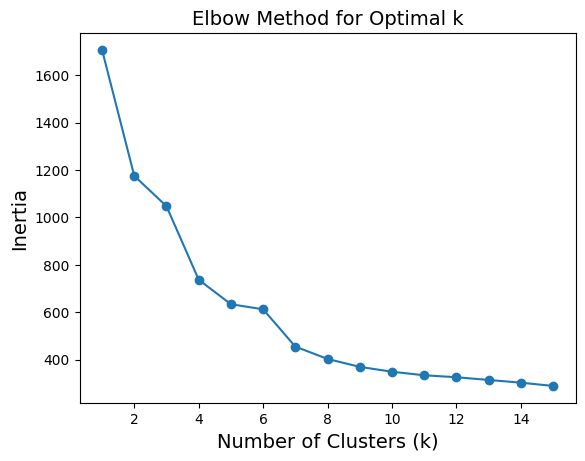

In [ ]:
k_values = range(1, 16)
inertias = []
for k in range(1, 16):  # Trying k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_value = getInertia(X, kmeans)
    inertias.append(inertia_value)  # Append the inertia value to the list

import matplotlib.pyplot as plt
plt.plot(range(1, 16), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
inertias

[1707.2294200296333,
 1175.5272754230887,
 1047.637440107815,
 737.3375265777405,
 633.8981217343638,
 612.5265360600234,
 455.1346559687473,
 402.95180539482647,
 369.5470403784881,
 349.01198737626066,
 334.0835071184207,
 325.7814609368013,
 314.3989573839941,
 302.83519254420395,
 289.12141962676276]

### Inertia calculation based on Saied's example - Option 3

In [ ]:
# #function for calculating inertia
# def getInertia(X,kmeans):
#     ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
#     inertia = 0
#     for J in range(len(X)):
#         inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
#     return inertia

In [ ]:
# #try different K values for clustering and find the optimal K
# inertias_1 = []
# silhouette_avgs = []
# max_K = 15
# for k in np.arange(1,max_K+1):
#     kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
#     inertias_1 = inertias_1 + [kmeans.inertia_]
#     if k>1:
#         silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]
#         print("silhouette_score: ",silhouette_score(X, kmeans.labels_)) #print silhouette score for the current K

In [ ]:
# inertias_1

### Number of clusters based on silhouette

In [ ]:
# Define range of k values to test
k_values = range(2, 16)  # Start from k=2
silhouette_scores = []

In [ ]:
# Compute silhouette score for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

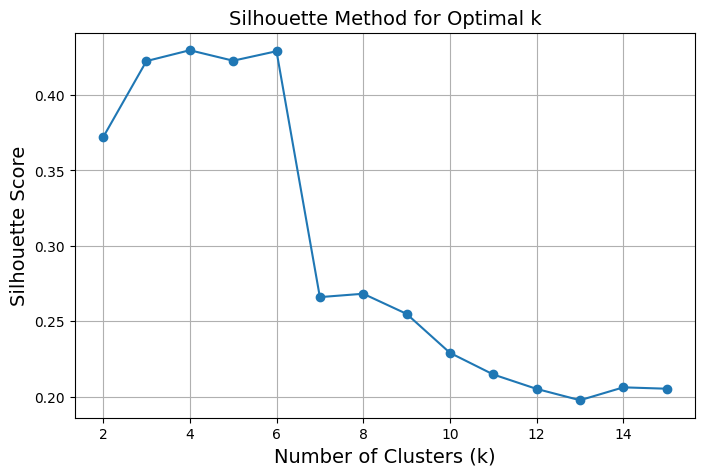

In [ ]:
# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.grid()
plt.show()

In [ ]:
silhouette_scores

[0.37191838565388746,
 0.4224469251347661,
 0.4296355372224769,
 0.4226849822459891,
 0.4289726637003929,
 0.26603924850957705,
 0.2682732536337197,
 0.25494375842336925,
 0.22911468400367224,
 0.214774338902207,
 0.20521139701831068,
 0.19772181425930668,
 0.20625804551127572,
 0.20534469393868507]

## Using optimal number of clusters to make a plot

### Fit KMeans and Get Cluster Assignments

In [ ]:
# Define the number of clusters (replace k with your optimal value)
k = 6  # Example, adjust based on previous analysis
kmeans = KMeans(n_clusters=k, random_state=42, n_init=7)
labels = kmeans.fit_predict(X)  # Cluster assignments for each client

### Plot Number of Clients in Each Cluster

<ipython-input-573-067e4a232378>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


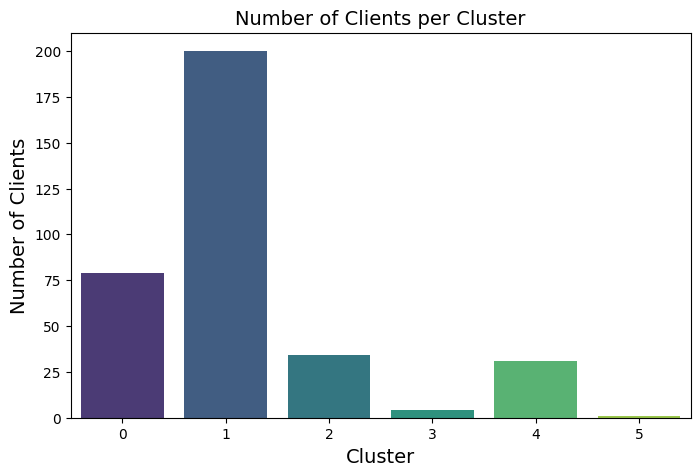

In [ ]:
import seaborn as sns

# Count number of clients per cluster
unique, counts = np.unique(labels, return_counts=True)

# Bar plot of clients per cluster
plt.figure(figsize=(8, 5))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Number of Clients")
plt.title("Number of Clients per Cluster")
plt.xticks(range(k))
plt.show()

### Plot All Consumption Curves per Cluster

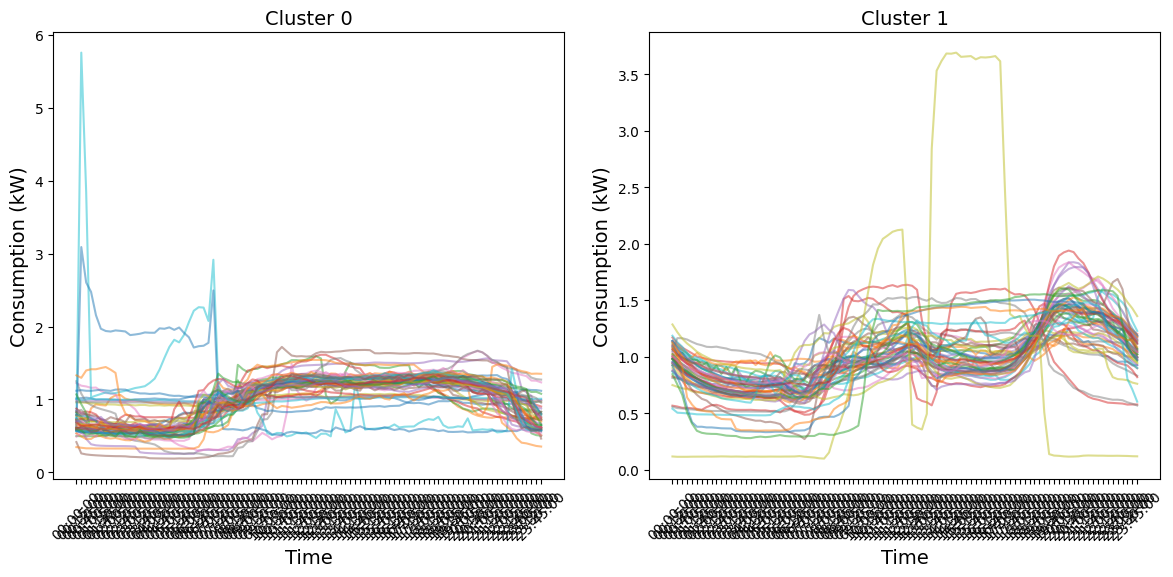

In [ ]:
# Plot each cluster's curves separately
plt.figure(figsize=(12, 6))

for cluster_id in range(k):
    plt.subplot(1, k, cluster_id + 1)  # Create subplots for each cluster
    for i in range(X.shape[0]):  # Iterate over all clients
        if labels[i] == cluster_id:
            plt.plot(average_curves_norm.index, X[i, :], alpha=0.5)  # Use index as time axis

    plt.title(f"Cluster {cluster_id}")
    plt.xlabel("Time")
    plt.ylabel("Consumption (kW)")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Plot consumption curves per cluster with corresponding centroid curve

In [ ]:
# # Plot centroid curves for each cluster
# plt.figure(figsize=(12, 6))

# for cluster_id in range(k):
#     plt.plot(average_curves_norm.index, kmeans.cluster_centers_[cluster_id].T, linewidth=2.5, label=f"Cluster {cluster_id}")

# # Customize plot
# plt.xlabel("Time")
# plt.ylabel("Consumption (kW)")
# plt.title("Centroid Curves of Each Cluster")
# plt.xticks(rotation=45)


# Exercise 2

## Prepping data

In [ ]:
#Selecting one client
oneClient = data_13_14['MT_022']

In [ ]:
oneClient.head()


,MT_022
2013-01-01 00:15:00,31.133250
2013-01-01 00:30:00,28.642590
2013-01-01 00:45:00,27.397260
2013-01-01 01:00:00,24.906600
2013-01-01 01:15:00,24.283935


In [ ]:
oneClient.tail()

,MT_022
2014-12-31 23:00:00,31.133250
2014-12-31 23:15:00,34.246575
2014-12-31 23:30:00,36.114570
2014-12-31 23:45:00,34.246575
2015-01-01 00:00:00,31.133250


In [ ]:
oneClient.shape

(70080,)

In [ ]:
oneClient.info()

<class 'pandas.core.series.Series'>
Index: 70080 entries, 2013-01-01 00:15:00 to 2015-01-01 00:00:00
Series name: MT_022
Non-Null Count  Dtype  
--------------  -----  
70080 non-null  float64
dtypes: float64(1)
memory usage: 1.1+ MB


In [ ]:
# Slice oneClient into 730 daily chunks (96 values each)
client = 'MT_022'
oneClient = data_13_14[client]
client = 'MT_022'
oneClient = data_13_14[client]
XX = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    XX.extend([np.array(oneClient[J*96:(J+1)*96])/np.mean(oneClient[J*96:(J+1)*96])])

In [ ]:
# Generates a list of all the days in the two years 2013-2014
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

In [ ]:
daysyear

['tue-2013-01-01',
 'wed-2013-01-02',
 'thu-2013-01-03',
 'fri-2013-01-04',
 'sat-2013-01-05',
 'sun-2013-01-06',
 'mon-2013-01-07',
 'tue-2013-01-08',
 'wed-2013-01-09',
 'thu-2013-01-10',
 'fri-2013-01-11',
 'sat-2013-01-12',
 'sun-2013-01-13',
 'mon-2013-01-14',
 'tue-2013-01-15',
 'wed-2013-01-16',
 'thu-2013-01-17',
 'fri-2013-01-18',
 'sat-2013-01-19',
 'sun-2013-01-20',
 'mon-2013-01-21',
 'tue-2013-01-22',
 'wed-2013-01-23',
 'thu-2013-01-24',
 'fri-2013-01-25',
 'sat-2013-01-26',
 'sun-2013-01-27',
 'mon-2013-01-28',
 'tue-2013-01-29',
 'wed-2013-01-30',
 'thu-2013-01-31',
 'fri-2013-02-01',
 'sat-2013-02-02',
 'sun-2013-02-03',
 'mon-2013-02-04',
 'tue-2013-02-05',
 'wed-2013-02-06',
 'thu-2013-02-07',
 'fri-2013-02-08',
 'sat-2013-02-09',
 'sun-2013-02-10',
 'mon-2013-02-11',
 'tue-2013-02-12',
 'wed-2013-02-13',
 'thu-2013-02-14',
 'fri-2013-02-15',
 'sat-2013-02-16',
 'sun-2013-02-17',
 'mon-2013-02-18',
 'tue-2013-02-19',
 'wed-2013-02-20',
 'thu-2013-02-21',
 'fri-2013-0

## Use Inertia to Find Optimal K

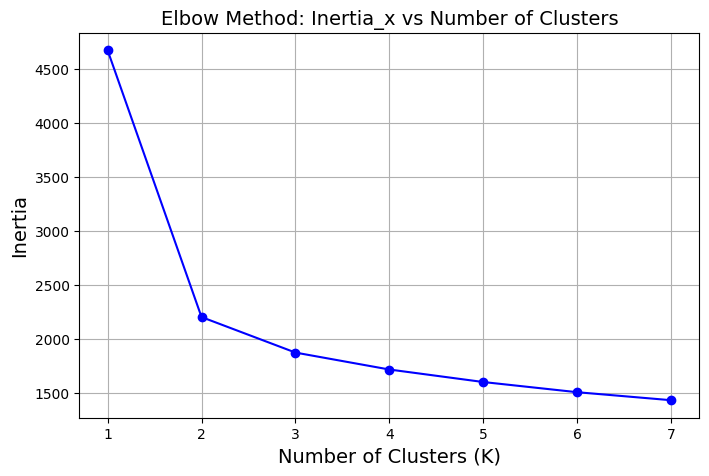

In [ ]:
inertia_x = []
K_range = range(1, 8)  # Try K values from 2 to 14

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(XX)
    inertia_x.append(kmeans.inertia_)

# Plot inertia vs number of clusters
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_x, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method: Inertia_x vs Number of Clusters")
plt.grid()
plt.show()

## Use Silhouette Score to Find Optimal K

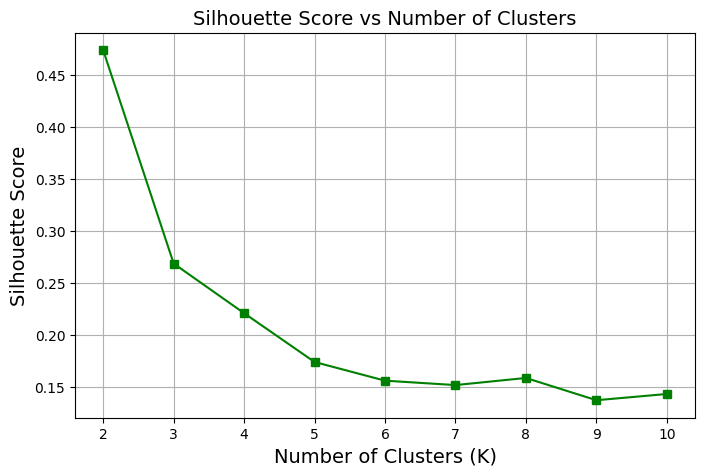

In [ ]:
k_values = range(2, 11)  # Start from k=2
silhouette_scores_x = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(XX)
    score = silhouette_score(XX, labels)
    silhouette_scores_x.append(score)

# Plot silhouette score vs number of clusters
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores_x, marker='s', linestyle='-', color='g')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.grid()
plt.show()

## Using optimal number of clusters group daily consumption curves

In [ ]:
# Define the number of clusters (replace k with your optimal value)
k = 2  # Example, adjust based on previous analysis
kmeans = KMeans(n_clusters=k, random_state=42, n_init=7)
labels_x = kmeans.fit_predict(XX)  # Cluster assignments for each day

## Plot all curves per cluster + centroid curve

In [ ]:
centroids = kmeans.cluster_centers_  # Cluster centroids

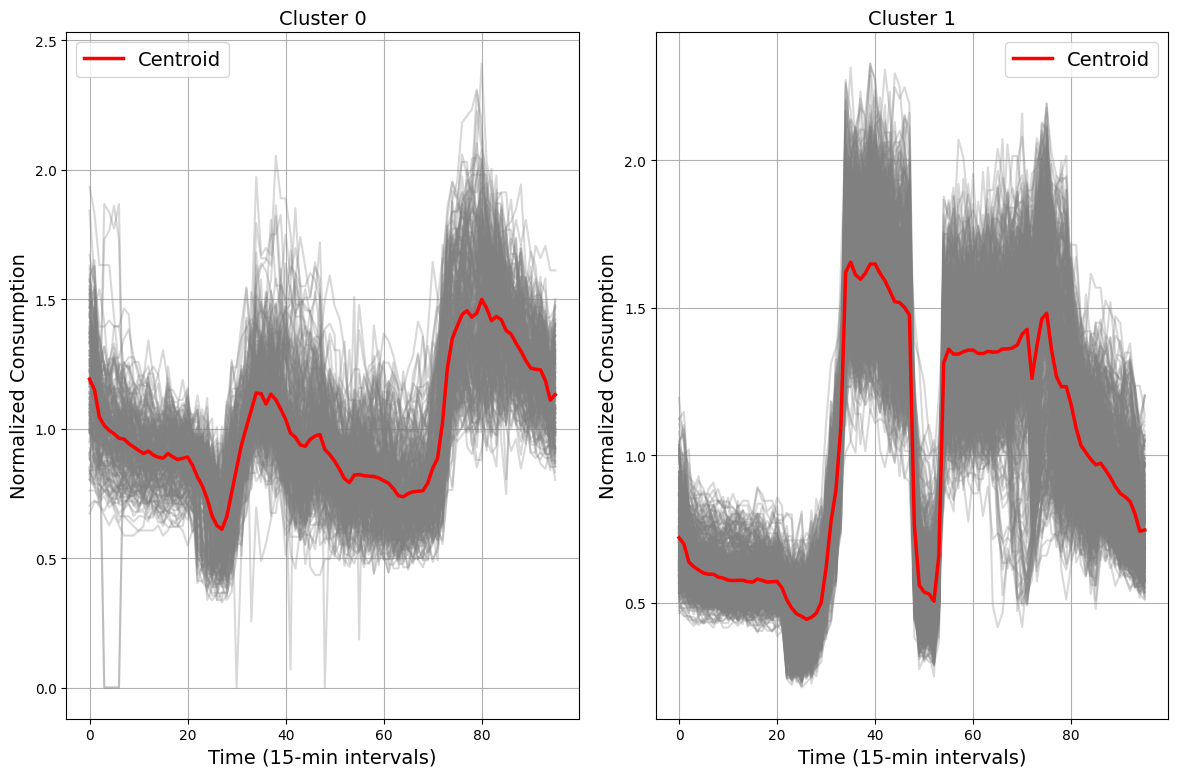

In [ ]:
# Define time axis for plotting (15-minute intervals)
time_axis = np.arange(96)  # 96 points per day (15 min x 96 = 24 hours)

# Plot each cluster separately
plt.figure(figsize=(12, 8))

for cluster_id in range(2):
    plt.subplot(1, 2, cluster_id + 1)  # Create subplots dynamically
    plt.title(f"Cluster {cluster_id}")

# Get all curves belonging to the cluster
    # Use list comprehension to filter XX based on labels_x
    cluster_curves = [XX[i] for i in range(len(XX)) if labels_x[i] == cluster_id]

# Plot all individual curves with low opacity
    for curve in cluster_curves:
        plt.plot(time_axis, curve, color='gray', alpha=0.3)

    # Plot the centroid curve (thicker line)
    plt.plot(time_axis, centroids[cluster_id], color='red', linewidth=2.5, label="Centroid")

    plt.xlabel("Time (15-min intervals)")
    plt.ylabel("Normalized Consumption")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

## Analyze results

### Create a DataFrame to Link Clusters with *Dates*

In [ ]:
# Create a DataFrame linking each day with its cluster
cluster_df = pd.DataFrame({
    "Date": daysyear,  # Format: "mon-YYYY-MM-DD"
    "Cluster": labels_x
})

# Extract weekday/weekend information
cluster_df["Day"] = cluster_df["Date"].apply(lambda x: x.split("-")[0])  # Extract "mon", "tue", etc.
cluster_df["Date"] = cluster_df["Date"].apply(lambda x: x.split("-")[1])  # Keep only "YYYY-MM-DD"

### Count Days per Cluster

<ipython-input-589-2ddde4bc98b7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


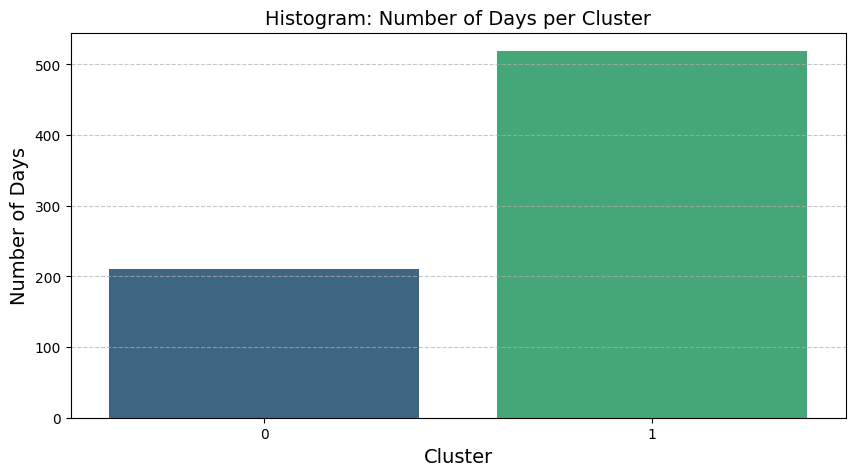

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count occurrences of each cluster
cluster_counts = cluster_df["Cluster"].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(10, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")

# Labels and title
plt.xlabel("Cluster")
plt.ylabel("Number of Days")
plt.title("Histogram: Number of Days per Cluster")
plt.xticks(range(len(cluster_counts)))  # Ensure x-axis shows all clusters
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

### Count Weekdays in Each Cluster

In [ ]:
# Create a pivot table to count weekdays per cluster
weekday_cluster_counts = cluster_df.pivot_table(index="Cluster", columns="Day", aggfunc="size", fill_value=0)

# Display the counts
print(weekday_cluster_counts)

Day      fri  mon  sat  sun  thu  tue  wed
Cluster                                   
0         11   12   52  104   11   11   10
1         93   92   52    0   93   94   95


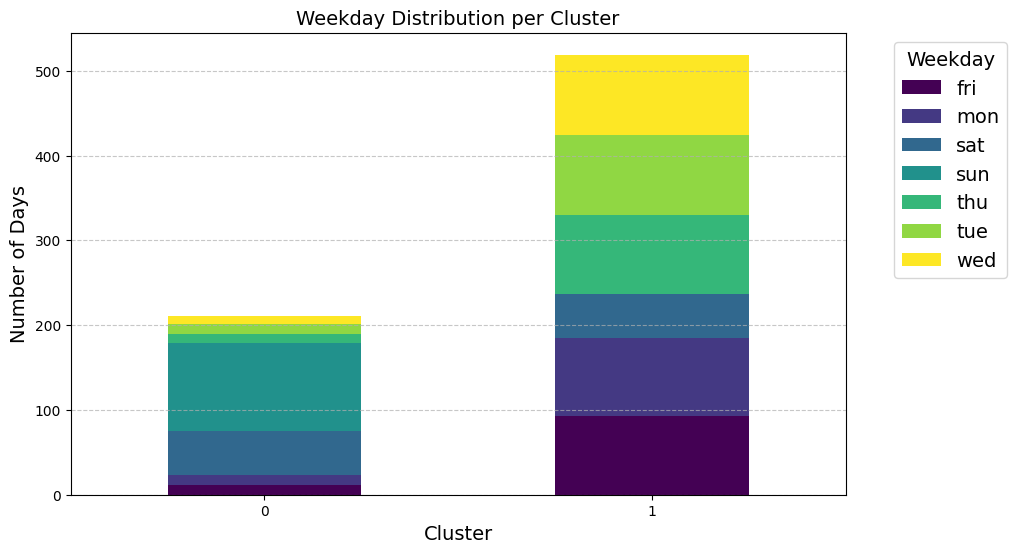

In [ ]:
# Plot stacked bar chart
weekday_cluster_counts.plot(kind="bar", stacked=True, colormap="viridis", figsize=(10, 6))

# Labels and title
plt.xlabel("Cluster")
plt.ylabel("Number of Days")
plt.title("Weekday Distribution per Cluster")
plt.legend(title="Weekday", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()